<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<br><h1>Mercedes Traffic Theory Programming</h1>

Written by Marc Zürn<br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />


<br><h2>Imports</h2>

In [1]:
import pandas as pd                    # Import for DataFrame 
import numpy as np                     # Import to round integer values
import seaborn as sns                  # enhanced data viz
import mysql.connector                 # Import to connect local MySQL Server
import matplotlib.pyplot as plt        # Import to create visuals
import statsmodels.formula.api as smf  # regression modeling

<br><h2>Connect to MySQL and Query Data</h2>

In [2]:
# Connect to my local MySQL database with Schema = "mercedes"
connection = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root1234',
    database='mercedes')

# try to connect and query the database trafficobjects
try:
    cursor = connection.cursor()
    sql_query = """ SELECT * 
                    FROM trafficobjects 
                    WHERE `date`='2009-12-10' 
                        AND type='JAM' 
                        AND time BETWEEN '06:00:00' AND '11:00:00' 
                        AND upstreampos < 130000 
                        AND road = 29
                    LIMIT 100000"""
    df = pd.read_sql(sql_query, connection)

# close connection    
finally:
    connection.close()

/Users/marc/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [3]:
# show the first 5 rows
df.head(5)

,Identifier,SITUATION,Type,ObjectId,Road,Date,Time,UpStreamPos,DownStreamPos,UpStreamSpeed,DownStreamSpeed,TrafficSpeed,QLKW,Timestamp,SumDeltaQ
0,5196111,DETECTORS,Jam,746295,29,2009-12-10,0 days 07:36:00,114133,114500,-22.048990,-18.727615,None,0.070000,2009-12-10 07:36:00,None
1,5196135,DETECTORS,Jam,746295,29,2009-12-10,0 days 07:37:00,113788,114500,-20.754898,-15.613875,None,0.118190,2009-12-10 07:37:00,None
2,5196157,DETECTORS,Jam,746295,29,2009-12-10,0 days 07:38:00,113497,114191,-17.469975,-18.585443,None,0.085200,2009-12-10 07:38:00,None
3,5196181,DETECTORS,Jam,746295,29,2009-12-10,0 days 07:39:00,113212,113889,-17.111292,-18.165350,None,0.065406,2009-12-10 07:39:00,None
4,5196229,DETECTORS,Jam,746318,29,2009-12-10,0 days 07:41:00,112318,112600,-16.937897,-18.172600,None,0.081395,2009-12-10 07:41:00,None


In [4]:
# check plausibilty of min, max, average values and distribution
df.describe()

,Identifier,ObjectId,Road,Time,UpStreamPos,DownStreamPos,UpStreamSpeed,DownStreamSpeed,QLKW
count,2.800000e+02,280.000000,280.0,280,280.000000,280.000000,280.000000,280.000000,280.000000
mean,5.198650e+06,746554.200000,29.0,0 days 08:35:37.500000,103053.892857,103934.903571,-15.585299,-15.857897,0.105919
std,1.271862e+03,164.392885,0.0,0 days 00:25:11.468523249,6325.991633,6244.958715,4.463090,2.823518,0.069566
min,5.196111e+06,746295.000000,29.0,0 days 07:36:00,87768.000000,88100.000000,-41.273232,-31.072479,0.000000
25%,5.197587e+06,746493.000000,29.0,0 days 08:17:00,98590.000000,99687.500000,-17.857614,-17.456757,0.061766
50%,5.198720e+06,746497.000000,29.0,0 days 08:38:00,103889.500000,104799.000000,-15.560923,-15.686190,0.083955
75%,5.199663e+06,746717.000000,29.0,0 days 08:54:15,107868.000000,108504.000000,-12.664276,-13.722535,0.140565
max,5.200844e+06,746892.000000,29.0,0 days 09:21:00,114234.000000,114500.000000,-5.734424,-10.344008,0.455882


<br><h2>Prepare Data</h2>

In [5]:
# Round spepd values to integers
df['UpStreamSpeed_Round'] = np.round(df['UpStreamSpeed'])
df['DownStreamSpeed_Round'] = np.round(df['DownStreamSpeed'])

# Count the number of each different speed
upstream_counts = df['UpStreamSpeed_Round'].value_counts().sort_index()
downstream_counts = df['DownStreamSpeed_Round'].value_counts().sort_index()


In [6]:
# show downstream
downstream_counts

-31.0     1
-26.0     1
-25.0     1
-23.0     2
-22.0     2
-21.0    10
-20.0     4
-19.0    24
-18.0    23
-17.0    38
-16.0    43
-15.0    38
-14.0    35
-13.0    27
-12.0    22
-11.0     7
-10.0     2
Name: DownStreamSpeed_Round, dtype: int64

<br><h2>Feature Engineering to Analyze Correlation of other Factors</h2>
analyse the correlation of factos like the hour and LKWs on both speeds

In [7]:
# prepare dataframe

# column to analyse the impact of hour
df['hour'] = df['Time'].dt.components.hours 

# column to analyse the impact of seconds since midnight
df['time_in_seconds'] = df['Time'].dt.total_seconds()

# column to analyse the impact of binary presence of a LKW
df['LKW_present'] = np.where(df['QLKW'] == 0, 0, 1)

In [8]:
# Define OLS Regression
lm_full = smf.ols(formula = """UpStreamSpeed_Round ~  hour +
                                                        time_in_seconds+
                                                        QLKW +
                                                        LKW_present""",
                               data = df)


# Fit the Model
results_full = lm_full.fit()


# printing the results
results_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     UpStreamSpeed_Round   R-squared:                       0.123
Model:                             OLS   Adj. R-squared:                  0.110
Method:                  Least Squares   F-statistic:                     9.612
Date:                 Fri, 23 Jun 2023   Prob (F-statistic):           2.74e-07
Time:                         12:08:05   Log-Likelihood:                -797.97
No. Observations:                  280   AIC:                             1606.
Df Residuals:                      275   BIC:                             1624.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -33.9418      6.578     -5.160      0.000     -46.891     -20.993
hour               -3.5227      0.852     -4.135      0.000      -5.200      -1.846
time_in_seconds     0.0017      0.000      5.738      0.000       0.001       0.002
QLKW               -9.2568      3.679     -2.516      0.012     -16.499      -2.015
LKW_present        -5.2556      4.252     -1.236      0.217     -13.626       3.114
==============================================================================
Omnibus:                       56.568   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.164
Skew:                          -0.898   Prob(JB):                     4.52e-35
Kurtosis:                       6.214   Cond. No.                     8.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# Define OLS Regression
lm_full = smf.ols(formula = """DownStreamSpeed_Round ~  hour +
                                                        time_in_seconds+
                                                        QLKW +
                                                        LKW_present""",
                               data = df)


# Fit the Model
results_full = lm_full.fit()


# printing the results
results_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     DownStreamSpeed_Round   R-squared:                       0.220
Model:                               OLS   Adj. R-squared:                  0.208
Method:                    Least Squares   F-statistic:                     19.37
Date:                   Fri, 23 Jun 2023   Prob (F-statistic):           4.70e-14
Time:                           12:08:05   Log-Likelihood:                -654.28
No. Observations:                    280   AIC:                             1319.
Df Residuals:                        275   BIC:                             1337.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -21.0142      3.937     -5.337      0.000     -28.765     -13.263
hour               -0.6060      0.510     -1.188      0.236      -1.610       0.398
time_in_seconds     0.0004      0.000      2.412      0.017    7.93e-05       0.001
QLKW              -18.8241      2.202     -8.549      0.000     -23.159     -14.489
LKW_present        -1.2865      2.545     -0.506      0.614      -6.297       3.724
==============================================================================
Omnibus:                        0.980   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.613   Jarque-Bera (JB):                1.054
Skew:                          -0.076   Prob(JB):                        0.590
Kurtosis:                       2.741   Cond. No.                     8.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<br><h2>Visualize Chart</h2>

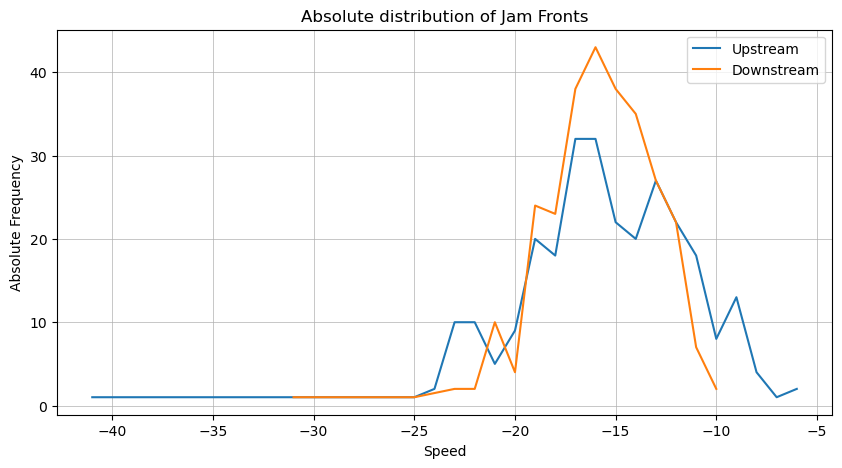

In [10]:
# Create plot with size
plt.figure(figsize=(10, 5))

# Plot the upstream and downstram with index values
plt.plot(upstream_counts.index, upstream_counts.values, label='Upstream')
plt.plot(downstream_counts.index, downstream_counts.values, label='Downstream')

# Set Title and Labels
plt.xlabel('Speed')
plt.ylabel('Absolute Frequency')
plt.title('Absolute distribution of Jam Fronts')

# add thin Grid Lines
plt.grid(True, linestyle='-', linewidth=0.5)

# Create legend
plt.legend()

plt.show()

<br><h2>Code Description</h2>

- The code establishes a connection to the previously created local MySQL Database, where it queries all rows from the 'trafficobjects' table.
- The output is stored in a Pandas dataframe to allow easy manipulation. As the 'StreamSpeeds' have decimal values, they are rounded to facilitate frequency analysis and create a more meaningful representation of data.
- To further analyze the impact of factors like time and the presence of LKWs, the code feature engineers additional attributes, such as a binary attribute indicating the presence of LKWs or the time since midnight in seconds.
- It then runs (OLS) Regression Models on both upstream and downstream speeds to identify relationships between these attributes and the speeds.
- Finally, the code ends with the visualization of the distribution of speeds to offer a clear, visual understanding of the data patterns.

<br><h2>Explanation</h2>
<h3>Theory Part 1</h3>
The theory that the downstream jam is relatively constant at -15km/h can be confirmed by the diagram, as the high point of the downstream distribution (orange line) is at almost -15km/h. 

<h3>Theory Part 2</h3>
When analysing the upstream front, it can be seen that it shows a wider distribution of speeds than the downstream front. This shows that the speed of this traffic front is more variable and could depend on other factors. Therefore, I did an OLS Regression on both the Down-, and UpstreamSpeed to assess the impact of the given and feature-engineered variables.<br><br>
- UpStreamSpeed_Round: the variables hour, time_in_seconds and QLKW are statistically significant for the UpStreamSpeed as their P-Value is smaller than 0.05. But the low R-squared of 12.3% indicates that only a few observations are adequately explained by the model.<br>
- DownStreamSpeed_Round: In this model, only the variables time_in_seconds with a positive correlation, and QLKW with a negative correlation are significant. But the R-squared of 22.0% indicates that, while the model explains a larger portion of the variability in the data compared to the previous model, a significant amount of variability still remains unexplained.<br><br>

There is a small correlation between the given attributes and both speeds, but the amount of non-explained observations is very big. Therefore, the thesis that the "velocity of the upstream front depends on the inflow" is true and I suggest to further analyze the traffic situation to find more attributes describing the situation."